In [1]:

import numpy as np
import random
import matplotlib.pyplot as plt
from proofreader.utils.data import *
from proofreader.utils.vis import *
import seaborn as sns

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
all_runs = {}
for ns in [1,2,3,4,5,6,7,8]:
    test = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs3_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    valid = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs3_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    all_runs[f'NS={ns}'] = (test, valid)

In [3]:
sns.set()
sns.color_palette("tab10")
FIG_SIZE = (10,6)

"""
    source: https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
"""

import matplotlib.pyplot as plt
import seaborn as sns

color_list = sns.color_palette("tab10")

sns.set_theme(rc={'axes.prop_cycle': plt.cycler(color=color_list),
            'lines.linewidth': 1.6,
            'lines.markersize': 10,
            'font.family': 'Arial',
            'font.size': 14,
            'axes.titlecolor':'black',
            'axes.titleweight':'bold',
            'axes.labelcolor':'black',
            'legend.facecolor': 'white',
            'legend.edgecolor': 'black',
            'figure.dpi': 100,
})


star = {'s': 128, 'zorder':2, 'marker':(5, 1), 'edgecolors': 'black'}

In [14]:
def plot_metric_vs_threshold(run_data, metric):

    # global plot params
    fig = plt.figure(figsize=FIG_SIZE)
    plt.title('Reduction in VI')
    plt.xlabel('Threshold')
    plt.ylabel(f'% Reduction in VI')

    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 110, 10))

    for run, data in run_data.items():
        x, y, = data
        x = x[:-1]
        y = y[:-1]

        plt.plot(x, y, marker='.', zorder=1, label=f'{run}')

        # highlight max
        max_i = np.argmax(y)
        plt.scatter(x[max_i], y[max_i], **star)
        # plt.annotate(f"{round(y[max_i]*100,1)}%", (x[max_i], y[max_i]), textcoords="offset points",  xytext=(
        #             32,2), ha='center', weight='bold', size=11)

    plt.scatter(None, None,  **star, color='k', label='Best VI')             
    plt.xlim((0.0, 1.0))
    plt.ylim((0, 120))
    plt.legend(loc='upper left')
    plt.show()

In [5]:
def plot_merge_curve(run_data, metric, thresholds):

    # global plot params
    plt.figure(figsize=FIG_SIZE)
    plt.title(metric)
    plt.xlabel('Merge Error')
    plt.ylabel(f'Merge Success')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))

    for itr, (run, data) in enumerate(run_data.items()):
        x, y, opt_i = data
        x = x[:-1]
        y = y[:-1]

        plt.plot(x,y, marker='.', zorder=1, label=f'{run}')
        plt.scatter(x[opt_i], y[opt_i], **star)

        # if itr == 0:
        #     for i in range(len(thresholds)):
        #         plt.annotate(f"{round(thresholds[i],2)}", (x[i], y[i]), textcoords="offset points",  xytext=(
        #             -16,8),  ha='center')

    plt.scatter(None, None, **star, color='k', label='Best VI')
    plt.legend(loc='lower right')
    plt.show()

In [6]:
def plot_ns_voi(ns, voi):

    # global plot params
    fig = plt.figure(figsize=FIG_SIZE)
    plt.title('Reducion in VI vs Number Missing Slices')
    plt.xlabel('Number Slices')
    plt.ylabel(f'% Reduction in VI')

    plt.xticks(np.arange(0, 10, 1))
    plt.yticks(np.arange(0, 100, 10))

    plt.plot(ns, voi, marker='.', zorder=1)
    
    plt.show()

In [7]:

def get_optimal_data_from_epochs(test, valid):
    best_e = 0
    best_voi = float('inf')
    for epoch, (x, y) in enumerate(valid['Voi Total']):
        min_voi = min(y)
        if min_voi < best_voi:
            best_e = epoch
            best_voi = min_voi
    total = len(valid['Voi Total']) 
    # print(f'optimal epoch: {best_e}/{total}')
    opt = {}
    for k in test.keys():
        opt[k] = (np.array(test[k][best_e][0]), np.array(test[k][best_e][1]))
    return opt

In [8]:
def covert_to_percent_reduction(x):
    no_action = x[-1]
    reduction = no_action - x
    percent_reduction = reduction/no_action
    return percent_reduction * 100

In [9]:
def gen_plt_for_metric(all_runs, metric):
    run_data = {} # r1 -> (r1_x, r1_y)
    for run, data in all_runs.items():
        opt = get_optimal_data_from_epochs(*data)
        x, y = opt[metric]
        y = covert_to_percent_reduction(y)
        run_data[run] = (x, y)
    plot_metric_vs_threshold(run_data, metric)

In [10]:
def gen_plt_for_merge(all_runs):
    run_data = {} # r1 -> (r1_x, r1_y)
    for run, data in all_runs.items():
        opt = get_optimal_data_from_epochs(*data)
        opt_i = np.argmin(opt['Voi Total'][1])
        x, y = opt['merge_curve']
        run_data[run] = (y, x, opt_i)
    thresholds = np.arange(0.1,1,0.1)
    plot_merge_curve(run_data, 'Merge Curve over Thresholds', thresholds)

In [11]:
def gen_plt_voi_vs_ns(all_runs):
    opt_vois = []
    ns = []
    for index, (run, data) in enumerate(all_runs.items()):
        opt = get_optimal_data_from_epochs(*data)
        opt_voi = np.min(opt['Voi Total'][1])
        total_voi = opt['Voi Total'][1][-1]
        opt_vois.append((total_voi - opt_voi)*100/total_voi)
        ns.append(index+1)
    plot_ns_voi(ns,opt_vois)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


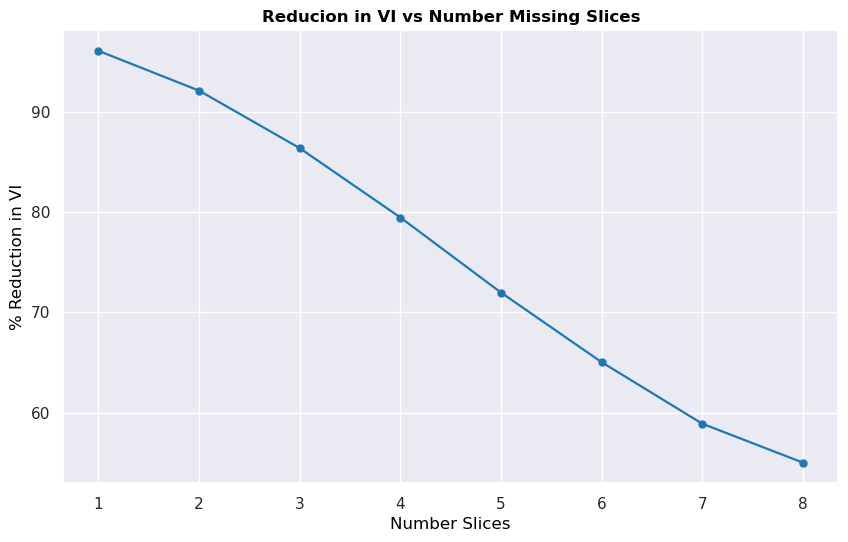

In [12]:
gen_plt_voi_vs_ns(all_runs)

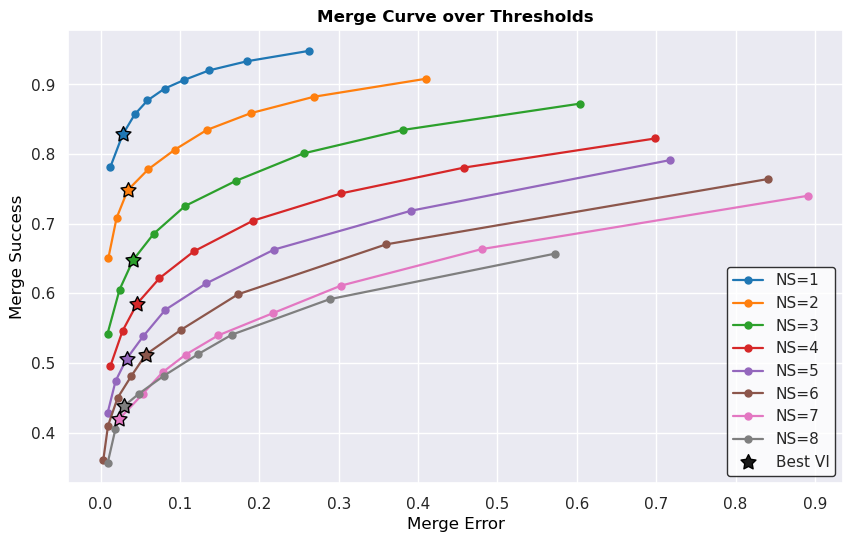

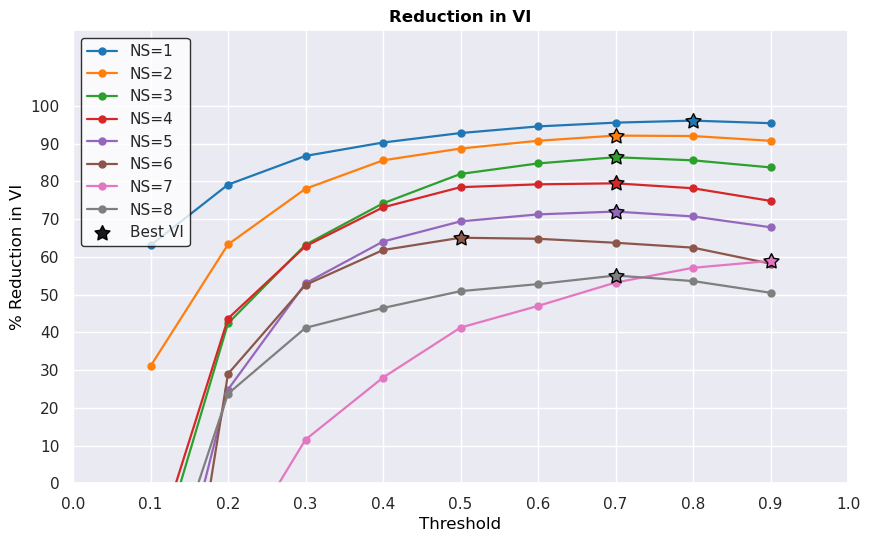

In [16]:
gen_plt_for_merge(all_runs)
gen_plt_for_metric(all_runs, 'Voi Total')
# gen_plt_for_metric(all_runs, 'Arand')

In [17]:
cross_runs = {}

for ns in [1,2,3,4,5]:
    test = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs1_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    valid = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs1_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    cross_runs[f'ns{ns}_cs1'] = (test, valid)
    

for ns in [1,2,3,4,5]:
    test = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs2_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    valid = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs2_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    cross_runs[f'ns{ns}_cs2'] = (test, valid)


for ns in [1,2,3,4,5]:
    test = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs3_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    valid = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs3_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    cross_runs[f'ns{ns}_cs3'] = (test, valid)


for ns in [1,2,3,4,5]:
    test = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs4_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    valid = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs4_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    cross_runs[f'ns{ns}_cs4'] = (test, valid)




In [18]:
cross_runs
opt_vois = []
css = [1, 2, 3, 4]
nss = [1,2,3,4,5]
cross_data = [[],[],[],[],[]]

for ns, cur_data in zip(nss,cross_data):
    for cs in css:
        t = f'ns{ns}_cs{cs}'
        data = cross_runs[t]
        opt = get_optimal_data_from_epochs(*data)
        opt_voi = np.min(opt['Voi Total'][1])
        total_voi = opt['Voi Total'][1][-1]
        cur_data.append((total_voi - opt_voi)*100/total_voi)


[[92.2053624911494, 95.67558977791737, 96.059492011007, 94.8972092340287], [85.7564191933149, 92.17952170017386, 92.09312232663525, 91.01526415441627], [79.19438214384289, 85.8233320913271, 86.35958761394645, 86.38406435318987], [69.7371358490814, 79.0852997137324, 79.45221912720277, 78.75602176509604], [63.502214626272924, 72.97562626433162, 71.97011328000305, 72.0008476109389]]


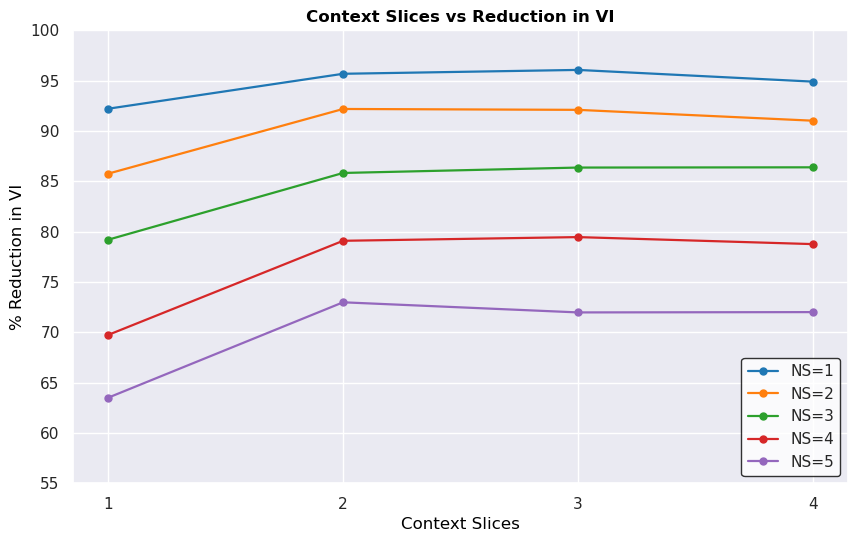

In [22]:
fig = plt.figure(figsize=FIG_SIZE)
for d in cross_data:
    plt.plot(css, d, marker='.')

plt.title('Context Slices vs Reduction in VI')
plt.xlabel('Context Slices')
plt.ylabel(f'% Reduction in VI')
plt.ylim([55,100])
plt.xticks(np.arange(1, 5, 1))
leg = []
for n in nss:
    leg.append(f'NS={n}')
plt.legend(leg)
plt.show()

In [24]:
all_pts = [2048,1024,512,256,128,64,32]

def load(ns):
    all_runs = {}
    # 2048 is default
    test = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs2_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    valid = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs2_t4_aligned_0/data/test.npy', allow_pickle=True).item()
    all_runs[2048] = (test, valid)

    for pts in all_pts[1:]:
        test = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs2_t4_aligned_{pts}_0/data/test.npy', allow_pickle=True).item()
        valid = np.load(f'/mnt/home/jberman/ceph/pf/CURVENET_ns{ns}_cs2_t4_aligned_{pts}_0/data/test.npy', allow_pickle=True).item()
        all_runs[pts] = (test, valid)

    return all_runs

def get_vois(all_runs):
    opt_vois = []
    for pt in all_pts:
        data = all_runs[pt]
        opt = get_optimal_data_from_epochs(*data)
        opt_voi = np.min(opt['Voi Total'][1])
        total_voi = opt['Voi Total'][1][-1]
        opt_vois.append((total_voi - opt_voi)*100/total_voi)
    
    return opt_vois

all_runs_ns1 = load(1)
all_runs_ns3 = load(3)
all_runs_ns5 = load(5)

voi_ns1 = get_vois(all_runs_ns1)
voi_ns3 = get_vois(all_runs_ns3)
voi_ns5 = get_vois(all_runs_ns5)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


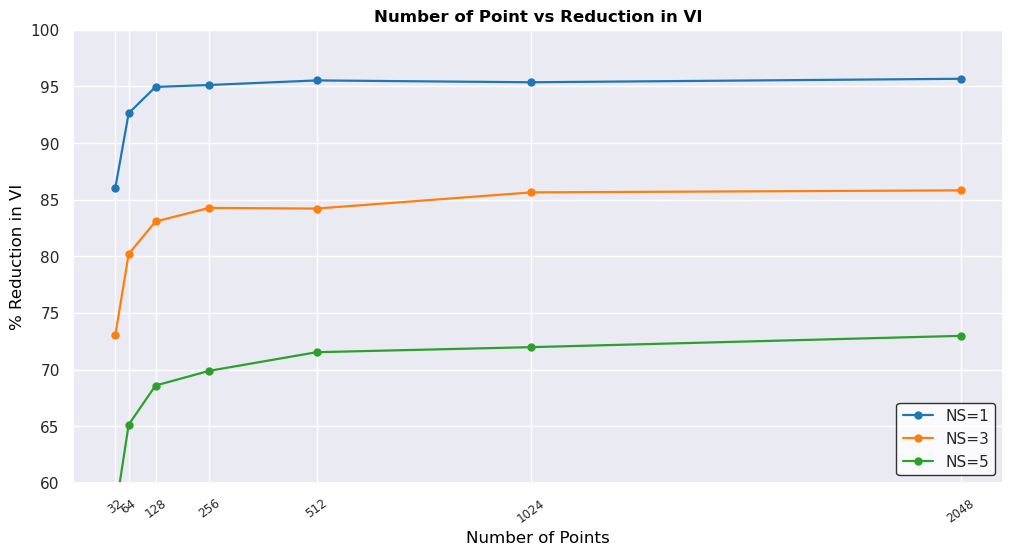

In [25]:

fig = plt.figure(figsize=(12,6))
plt.plot(all_pts, voi_ns1, marker='.', label='NS=1')
plt.plot(all_pts, voi_ns3, marker='.', label='NS=3')
plt.plot(all_pts, voi_ns5, marker='.', label='NS=5')

plt.title('Number of Point vs Reduction in VI')
plt.xlabel('Number of Points')
plt.ylabel(f'% Reduction in VI')
plt.ylim([60,100])
plt.xticks(all_pts, fontsize=8.6, rotation=36)
plt.legend()
plt.show()